## Implementation of RBF network

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
def generate_data(file):
    
    data = pd.read_csv(file, sep = ' ', header = None)
    X = data.loc[:, :8]
    Y = np.array(data.loc[:, 9:])
    
    return X, Y

In [73]:
class RBF_Network:
    """RBF Network using k-means."""
    
    def train(self, X, Y, k, gamma, lamb):
        
        N = X.shape[0]; self.gamma = gamma
        self.clusters, self.centers = self.run_kmeans(k, X)
        
        # feature transform from RBF
        Z = np.array([[self.RBF_kernel(x, mu, self.gamma) for mu in self.centers] for x in X.values])
        assert(Z.shape == (N, k))
        
        # compute beta of regularized full RBF Network
        inv = np.linalg.inv(np.dot(Z.T, Z) + np.identity(Z.shape[1]) * lamb)
        self.beta = inv.dot(Z.T).dot(Y)   
        
        return self.beta, self.centers
        
    
    def predict(self, X_test, binary_class = True):
        
        Z_test = np.array([[self.RBF_kernel(x, mu, self.gamma) for mu in self.centers] for x in X_test.values])
        return np.sign(Z_test.dot(self.beta)) if binary_class else Z_test.dot(self.beta)     
        
        
    def RBF_kernel(self, x, mu, gamma):
        return np.exp(-gamma * np.sum((x - mu)**2))
    
    
    def run_kmeans(self, k, data):
        data = data
        N = data.shape[0]
    
        # initialize mu
        mu = data.sample(k).values

        # alternating optimization
        converge = False
        while not converge:
            # cluters dictionary to store data in each cluster
            clusters = {i: [] for i in range(len(mu))}

            # partition
            for x in data.values:
                dist = [np.sum((x - center)**2) for center in mu]
                clusters[np.argmin(dist)].append(x)

            # update mu
            for j in clusters:
                new_mu = sum(clusters[j]) / len(clusters[j])
                if np.array_equal(new_mu, mu[j]):
                    mu[j] = new_mu
                else:
                    converge = True   # stop while converge

        return clusters, mu
        

In [47]:
train_file = 'data/hw8_train.dat.txt'; test_file = 'data/hw8_test.dat.txt'
X_train, Y_train = generate_data(train_file); X_test, Y_test = generate_data(test_file)


RBF Network Using k-Means with k = 2
	  Gamma = 0.001; Training error: 55.00%; Testing error: 53.30%
	  Gamma = 0.100; Training error: 69.00%; Testing error: 65.10%
	  Gamma = 1.000; Training error: 58.00%; Testing error: 55.60%
	  Gamma = 10.000; Training error: 67.00%; Testing error: 58.70%
	  Gamma = 100.000; Training error: 55.00%; Testing error: 49.20%

RBF Network Using k-Means with k = 4
	  Gamma = 0.001; Training error: 57.00%; Testing error: 53.70%
	  Gamma = 0.100; Training error: 61.00%; Testing error: 63.50%
	  Gamma = 1.000; Training error: 77.00%; Testing error: 64.50%
	  Gamma = 10.000; Training error: 73.00%; Testing error: 63.90%
	  Gamma = 100.000; Training error: 50.00%; Testing error: 45.80%

RBF Network Using k-Means with k = 6
	  Gamma = 0.001; Training error: 64.00%; Testing error: 60.20%
	  Gamma = 0.100; Training error: 68.00%; Testing error: 62.30%
	  Gamma = 1.000; Training error: 64.00%; Testing error: 54.90%
	  Gamma = 10.000; Training error: 53.00%; Testi

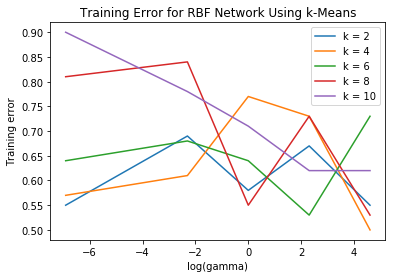

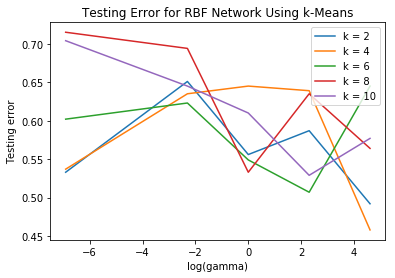

In [103]:
K = [2, 4, 6, 8, 10]               # for k-means clustering
gamma = [0.001, 0.1, 1, 10, 100]   # for guassian kernel
lamb = 0                           # for regularization

start = time.clock()

# create figures
plt.figure(1)
plt.title('Training Error for RBF Network Using k-Means'); plt.xlabel('log(gamma)'); plt.ylabel('Training error')
plt.figure(2)
plt.title('Testing Error for RBF Network Using k-Means'); plt.xlabel('log(gamma)'); plt.ylabel('Testing error')


for k in K:
    print('\nRBF Network Using k-Means with k = %d' %k)
    RBFnet = RBF_Network()
    
    train_err = []; test_err = []
    for r in gamma:
        RBFnet.train(X_train, Y_train, k, r, lamb)
        err_in = np.sum(Y_train == RBFnet.predict(X_train)) / len(Y_train)
        err_out = np.sum(Y_test == RBFnet.predict(X_test)) / len(Y_test)
        train_err.append(err_in); test_err.append(err_out)
        
        print('\t  Gamma = %.3f; Training error: %.2f%%; Testing error: %.2f%%' %(r, (err_in * 100),(err_out * 100)))

    plt.figure(1)
    plt.plot(np.log(gamma), train_err, label = 'k = %d' %k); plt.legend()
    
    plt.figure(2)
    plt.plot(np.log(gamma), test_err, label = 'k = %d' %k); plt.legend()


print('Using %.4f seconds.' % (time.clock() - start))

K = 4; error = 0.083731
K = 6; error = 0.082252
K = 8; error = 0.082140
K = 10; error = 0.082104


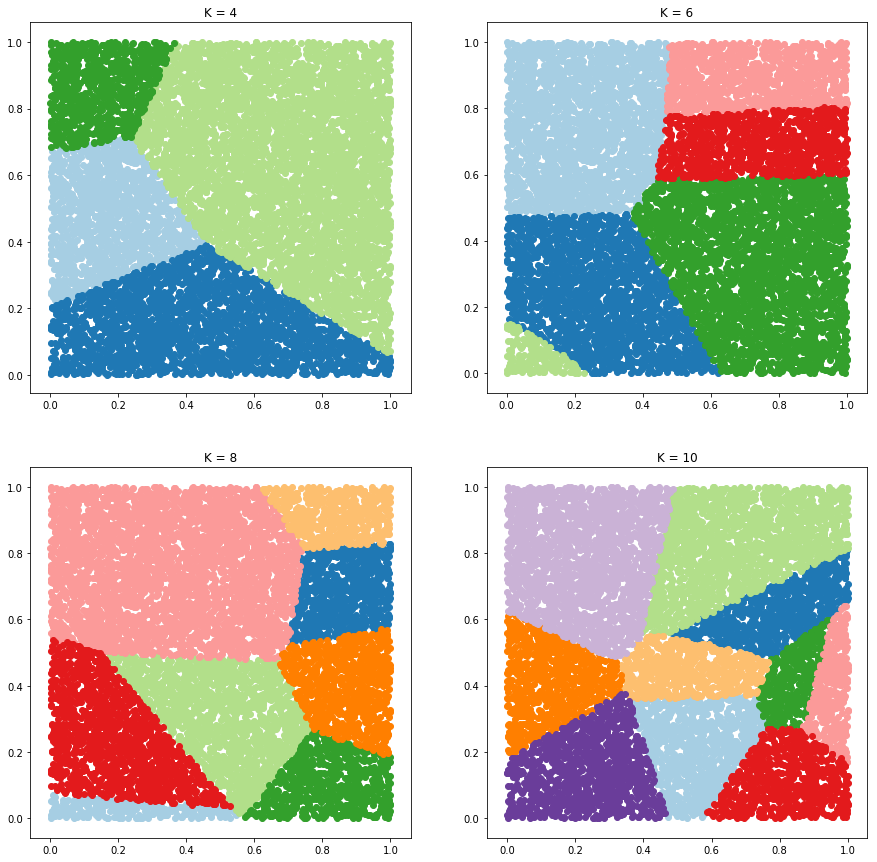

In [159]:
K = [4, 6, 8, 10]  
gamma = 1
lamb = 0     

# generate artificial random data
X = pd.DataFrame(np.random.random((10000, 2)))
Y = np.random.rand(10000)

plt.figure(figsize=(15, 15))
colors = np.array(['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c',
                   '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a'])

for j in range(len(K)):
    RBFnet = RBF_Network()
    RBFnet.train(X, Y, K[j], gamma, lamb)
    mse = np.mean((RBFnet.predict(X, binary_class = False) - Y) ** 2)
    print('K = %d; error = %f' %(K[j], mse))

    for i in list(RBFnet.clusters.keys()):
        cluster_data = pd.DataFrame(RBFnet.clusters[i])
        plt.subplot(2,2,j+1)
        plt.scatter(cluster_data[0], cluster_data[1], color = colors[i])
        plt.title('K = %d' %K[j])